In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [3]:
#data = np.load("../data/npy/ES1_R1.npy")

### Synth data

In [77]:
def create_clust(dim):
    center = np.random.random(dim)*np.random.randint(1,200)
    
    #cov_1 = np.random.random((dim,dim))
    #cov_1 += cov_1.T
    #while not all(np.linalg.eigvals(cov_1) > 0):
    #    cov_1 = np.random.random((dim,dim))
    #    cov_1 += cov_1.T
    
    cov_1 = np.diag(np.ones(dim))
    
    return np.random.multivariate_normal(center, cov_1 * 2, 1000)

In [105]:
clust_1 = create_clust(2)
clust_2 = create_clust(2)
#clust_3 = create_clust(4)

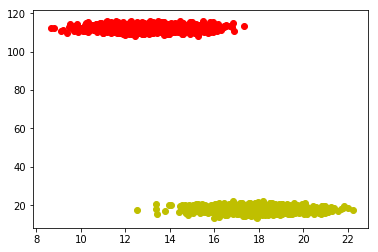

In [106]:
plt.scatter(clust_1[:,0],clust_1[:,1], c='y' )
plt.scatter(clust_2[:,0],clust_2[:,1], c='r' )
#plt.scatter(clust_3[:,0],clust_3[:,1], c='b' )
#plt.scatter(data_2[:,0],data_2[:,1], c='b' )
plt.show()

In [107]:
data = np.concatenate((clust_1, clust_2))

In [80]:
data = clust_1

In [108]:
# Training Parameters
#learning_rate = 0.001
#num_steps = 30000
batch_size = 50
clusters_num = 1

#display_step = 1000
#examples_to_show = 10

# Network Parameters
num_hidden_1 = 2 # 1st layer num features
int_dim = 2 # 2nd layer num features (the latent dim)
num_input = 2 # MNIST data input (img shape: 28*28)

In [120]:
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_input])
learning_rate = tf.placeholder( dtype=tf.float32)

weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([num_input, num_hidden_1]) / 10),
    'encoder_h2': tf.Variable(tf.truncated_normal([num_hidden_1, int_dim]) / 10),
    'decoder_h1': tf.Variable(tf.truncated_normal([int_dim, num_hidden_1]) / 10),
    'decoder_h2': tf.Variable(tf.truncated_normal([num_hidden_1, num_input]) / 10),
    'predictor_h_1': tf.Variable(tf.truncated_normal([int_dim + 1, num_hidden_1]) / 10),
    'predictor_h_2': tf.Variable(tf.truncated_normal([num_hidden_1, clusters_num]) / 10)
}
biases = {
    'encoder_b1': tf.Variable(tf.truncated_normal([num_hidden_1]) / 10),
    'encoder_b2': tf.Variable(tf.truncated_normal([int_dim]) / 10),
    'decoder_b1': tf.Variable(tf.truncated_normal([num_hidden_1]) / 10),
    'decoder_b2': tf.Variable(tf.truncated_normal([num_input]) / 10),
    'predictor_b_1': tf.Variable(tf.truncated_normal([num_hidden_1]) / 10),
    'predictor_b_2': tf.Variable(tf.truncated_normal([clusters_num]) / 10)
}

# Building the encoder

    # Encoder Hidden layer with sigmoid activation #1
#enc_layer_1 = tf.add(tf.matmul(X, weights['encoder_h1']),
#                                   biases['encoder_b1'])
    # Encoder Hidden layer with sigmoid activation #2
z = tf.nn.relu(tf.add(tf.matmul(X, weights['encoder_h2']),
                                   biases['encoder_b2']))


# Building the decoder

    # Decoder Hidden layer with sigmoid activation #1
#dec_layer_1 = tf.add(tf.matmul(z, weights['decoder_h1']),
#                                   biases['decoder_b1'])
    # Decoder Hidden layer with sigmoid activation #2
decoder = tf.add(tf.matmul(z, weights['decoder_h2']),
                                   biases['decoder_b2'])

In [121]:
mse = tf.reduce_mean(tf.squared_difference(decoder, Y))

In [32]:
predictor_inp = tf.concat([z, tf.reshape(mse, (-1,1))], axis = 1)

In [33]:
predictor_layer_1 = tf.nn.relu(tf.add(tf.matmul(predictor_inp, weights['predictor_h_1']),
                                   biases['predictor_b_1']))
gamma = tf.nn.softmax(tf.add(tf.matmul(predictor_layer_1, weights['predictor_h_2']),
                                   biases['predictor_b_2']))

In [34]:
def est_gmm(gamma, z):
    weights = tf.reduce_mean(gamma, reduction_indices=[0])
    means = tf.transpose(tf.matmul(tf.transpose(z), gamma) / tf.transpose(tf.reduce_sum(gamma, reduction_indices=[0])))
    
    z_minus_means = tf.map_fn(lambda x: z - x, means)

    def internal(x):
        x = tf.reshape(x, (1,-1))
        return tf.matmul(tf.transpose(x), x)

    matrixes = tf.map_fn(lambda x: tf.map_fn(internal, x), z_minus_means)
    
    m_r = tf.reshape(matrixes, (clusters_num * batch_size, int_dim * int_dim))
    m_r2 = tf.reshape(matrixes, (clusters_num * batch_size, int_dim * int_dim)) * tf.reshape(tf.transpose(gamma), (clusters_num * batch_size,1))
    m_r3 = tf.reduce_sum(tf.reshape(m_r2, (clusters_num,batch_size,int_dim,int_dim)), [1]) 
    sigmas = tf.reshape(tf.transpose(tf.transpose(tf.reshape(m_r3, (clusters_num, int_dim * int_dim))) / tf.reduce_sum(gamma, 0)), (clusters_num,int_dim,int_dim))
    
    means_minus_z = tf.map_fn(lambda x: means - x, z)
    
    def internal_e_1(z):
        #return (-0.5 * tf.map_fn(lambda x: tf.matmul(tf.matmul(tf.reshape(x, (1, -1)), z[1]), tf.reshape(x, (-1,1))), z[0]), 0.)
        #return tf.map_fn(lambda x,y: (tf.matmul(tf.reshape(x, (1, -1)), y), 0.), (z, sigmas), dtype=(tf.float32, tf.float32))[0]
        return tf.exp( -0.5 * 
            tf.map_fn(lambda x: tf.matmul(tf.matmul(tf.reshape(x, (1, -1)), tf.linalg.inv(z[1])),  tf.reshape(x, (-1, 1))),
                      z[0])) / tf.sqrt(tf.abs(tf.linalg.det(z[1])))

    #en_1 = tf.map_fn(lambda x: tf.transpose(x, (1,0,2)),means_minus_z)#, dtype=(tf.float32, tf.float32))
    en_1 = tf.transpose(means_minus_z, (1,0,2))

    en_2 = tf.map_fn(internal_e_1, (en_1, sigmas), dtype=(tf.float32))

    en = tf.reduce_mean(-tf.log(tf.reduce_sum(tf.transpose(tf.reshape(en_2, (clusters_num, batch_size))) * weights, 1)))
    
    return weights, means, sigmas, en

In [35]:
w, m, s, e = est_gmm(gamma, z)

In [122]:
# Define loss and optimizer, minimize the squared error
#loss = tf.reduce_mean(mse)#+ 0.01 * e + tf.reduce_sum(0.001 / s)
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(mse)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [123]:
sess.close()

In [124]:
sess = tf.Session()
sess.run(init)

# Training

In [139]:
epochs = 200
losses = []

In [126]:
batch_size

50

In [127]:
sess.run([mse], feed_dict={X: data[0:10], Y: data[0:10]})

[318.40973]

In [137]:
lr = 0.01

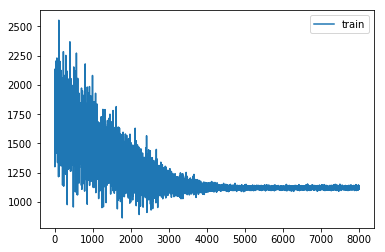

In [140]:
for i in range(epochs):
    for batch in iterate_minibatches(data, batch_size, shuffle = True):
        _, l = sess.run([optimizer, mse], feed_dict={X: batch, Y: batch, learning_rate : lr})
        losses.append(l)
    # Display logs per step
    
    if i % 1 == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
        
        display.clear_output(wait=True)
        plt.plot(losses, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()
        
    #lr *= 0.95


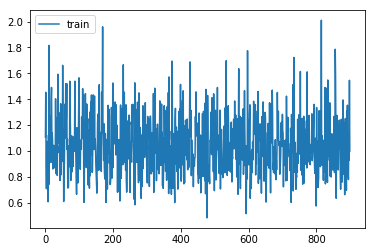

In [72]:
plt.plot(losses[300:], label='train')
#    plt.plot(v_losses_valid, label='validation')
plt.legend()
plt.show()

In [91]:
sess.run([z], {X: data[:10]})

[array([[ 12.87011051,  17.34328651],
        [ 12.66462135,  18.80195427],
        [ 14.95114326,  14.5014801 ],
        [ 11.42245865,  15.55746651],
        [ 11.64191723,  18.03108788],
        [ 13.07362461,  16.70184135],
        [ 13.24153614,  17.46023369],
        [ 12.86480808,  18.29295921],
        [ 12.65094566,  15.27075768],
        [ 14.09473801,  12.84844017]], dtype=float32)]

In [119]:
np.dot(sess.run(weights['encoder_h2']), sess.run(weights['decoder_h2']))

array([[ 0.88324738,  0.01095954],
       [-0.01131704,  1.00339389]], dtype=float32)

In [73]:
sess.run(weights['decoder_h2'])

array([[-0.43715525, -0.56410933],
       [-0.4207879 , -0.56385201]], dtype=float32)

In [42]:
data_2 = sess.run([decoder], {X: data}) [0]

In [103]:
data_2[:10]

array([[ 15.8507061 ,  21.12286186],
       [ 17.508461  ,  23.1594677 ],
       [ 14.8723259 ,  19.85094833],
       [ 17.49960518,  23.23057938],
       [ 18.78596497,  24.82101822],
       [ 17.08238411,  22.77754593],
       [ 17.94906616,  23.86109161],
       [ 17.05692101,  22.53181458],
       [ 17.21934128,  23.06864929],
       [ 18.08721542,  24.29743576]], dtype=float32)

In [41]:
data[:10]

array([[ 15.50276192,  21.60550506],
       [ 18.84553069,  21.98820822],
       [ 14.22770353,  20.61880886],
       [ 18.00966429,  22.87807179],
       [ 20.50274117,  23.28494269],
       [ 16.57437944,  23.42940047],
       [ 18.13444304,  23.83397632],
       [ 18.66253597,  21.09073066],
       [ 15.62489013,  24.79739923],
       [ 15.75296955,  26.76622801]])

In [13]:
summ_writer = tf.summary.FileWriter("/home/anton/TF_logs/CRISPR/", sess.graph, filename_suffix="AE_2")

In [37]:
summ_writer.close()

In [24]:
#gamma = tf.placeholder(tf.float32)
#z = tf.placeholder(tf.float32)    

weights = tf.reduce_mean(gamma, reduction_indices=[0])
means = tf.transpose(tf.matmul(tf.transpose(z), gamma) / tf.transpose(tf.reduce_sum(gamma, reduction_indices=[0])))

z_minus_means = tf.reshape(tf.map_fn(lambda x: z - x, means), [-1, int_dim])

z_minus_means_squared = tf.map_fn(lambda x: tf.reduce_sum(x * x), z_minus_means)

sigma_flat = tf.reduce_sum(tf.transpose(tf.reshape(
        z_minus_means_squared * tf.reshape(tf.transpose(gamma), (1, -1)), [clusters_num, batch_size])), 0) / tf.reduce_sum(gamma, 0)

pre_energy = tf.reduce_sum(tf.exp(-0.5 * tf.transpose(
    tf.reshape(z_minus_means_squared,  [clusters_num, batch_size])) / sigma_flat) * weights  / tf.sqrt(6.28  * sigma_flat),1 )
                           
energy = tf.reduce_mean(-tf.log(tf.reduce_sum(tf.exp(-0.5 * tf.transpose(
    tf.reshape(z_minus_means_squared,  [clusters_num, batch_size])) / sigma_flat) * weights  / tf.sqrt(6.28  * sigma_flat), 1)))